## Дерево решений (CART algorithm)



В данном примере примере рассмотрим алгоритм дерева решений для задач регрессии. 

     В качестве алгоритма используем алгоритм CART, т.к. он наиболее гибкий, может решать задачи как регрессии, так и классификации.
Данный алгоритм разбивает данные и по категориальным признакам и по непрерывным. В процессе роста дерева алгоритм CART проводит для каждого узла полный перебор всех атрибутов, на основе которых может быть построено разбиение, и выбирает тот, который максимизирует значение *Прироста информации*

 - Для задач классификации в качестве *критерия информативности* обычно используется критерий Джинни 

 - Для задач регрессии можно в качестве *критерия информативности* использовать MSE, MAE 

Основная идея алгоритма заключается в том, чтобы выбрать такое разбиение из всех возможных в данном узле, чтобы полученные дочерние узлы были максимально однородными. При этом каждое разбиение производится только по одному атрибуту.

Алгоритм CART предназначен для построения бинарного дерева решений. Бинарные (двоичные) деревья — деревья, каждый узел которых при разбиении имеет только двух потомков.

### Немного о идее предсказания непрерывной величины (Дерево решений для задач регрессии)
- 1) Создается корневой узел
- 2) выбирается первый признак, по которому будет идти разбиение объектов.
- 3) у данного признака выбираются все возможные "Пороговые значения", по которым будут разбиваться данные
- 4) При каждом потенциальном разбиении рассчитывается прирост информации.

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

В случае **регрессии** разброс будет характеризоваться дисперсией или же *среднеквадратичным отклонением*, поэтому критерий информативности будет записан в виде

$$H(X) = \frac{1}{X}\sum_{i\in X}(y_{i} - \bar{y}(X))^{2},$$
 
 - 5) Находим "лучшее" пороговое значение и признак, которые обеспечивают максимум прироста инфромации. 
 - 6) Разбиваем наш узел на два потомка (Алгоритм CART является бинарным и создает двоичное дерево, узел делится на два потомка)
 - 7) Когда доходим до листа (Создать лист можно разными путями, о критериях останова поговорим позже), в качестве предсказания в листе берем среднее по объектам в листе целевой переменной (Задача регрессии)

### Критерии останова:
- 1) Минимальное количество объектов в листе (избавляемся от переобучения)
- 2) Глубина дерева
- 3) Прирост информации равен нулю или совсем незначительный
- 4) Количество листьев

### Реализация

- Для работы с данным я использую две библиотеки, это numpy и pandas

In [1]:
import numpy as np
import pandas as pd

- Реализация функции рассчитывающей MSE

In [2]:
def mse(y):
    return np.mean((y - y.mean())**2)

- Функция рассчитывающая прирост информации

In [3]:
def gain(mse_root, right_data, left_data):
    p = float(right_data.shape[0]) / (right_data.shape[0] + left_data.shape[0])
    return mse_root - p*mse(right_data) - (1-p)*mse(left_data)

- Функция разбиения объектов узла на две выборки

In [4]:
def split(X, y, index, t):
    
    left = np.where(X[:, index] <= t)
    right = np.where(X[:, index] > t)
    
    true_data = X[left]
    false_data = X[right]
    
    true_pred = y[left]
    false_pred = y[right]
    
    return false_data, true_data, false_pred, true_pred

- Функция, которая находит наилучшее разбиение

In [5]:
def find_best_split(X, y):
    # Минимальное количество элементов в узле = 5
    min_samples_leaf = 5
    
    best_gain = 0
    
    best_t = None # Лучшее пороговое значение
    best_index = None # Индекс лучшего признака
    
    root_mse = mse(y) # Критерий информативности у предка
    
    n_features = X.shape[1] # Кол. признаков
    for index in range(n_features):
        
        t_values = np.unique(X[:, index])
        
        for t in t_values:
            false_data, true_data, false_pred, true_pred  = split(X, y, index, t)
            
            if len(false_data) < min_samples_leaf or len(true_data) < min_samples_leaf: # Критерий останова
                continue
                
            current_gain = gain(root_mse, false_pred, true_pred) # Текущий прирост инфрмации
            
            if current_gain > best_gain: # Лучший прирост информации
                best_gain = current_gain
                best_t = t
                best_index = index
        
    return best_gain, best_t, best_index 

In [6]:
def build_tree(X, y): # Рекурсивное построение дерева
    gain, t, index = find_best_split(X, y)
    print(gain, t)
    if gain == 0:
        return Leaf(X, y)
    false_data, true_data, false_pred, true_pred = split(X, y, index, t)
    
    true_branch = build_tree(true_data, true_pred)
    
    false_branch = build_tree(false_data, false_pred)
    
    return Node(index, t, true_branch, false_branch)

In [7]:
class Node: # Реализация класса узла
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index #Индекс признака, по которому мы сравниваем значения с пороговым
        self.t = t #пороговое значение
        self.true_branch = true_branch # Поддерево удовлетворяещее условию 
        self.false_branch = false_branch # Поддерево не удовлетворяещее условию 
    

In [8]:
class Leaf: # Реализация класса листа
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.predict = self.y.mean() # В качестве ответа, берем среднее

In [9]:
from sklearn.datasets import make_regression # С помощью данной библиотеки создаем рандомный датасет 

In [10]:
# У нас будет 2 признака, и оба будут корреллировать с целевой переменной
X, y = make_regression(n_features=2, n_informative=2, random_state=5)

In [11]:
from sklearn.model_selection import train_test_split
# Разбиваем на выборку на тестовую 
train_X, test_X, train_y, test_y = train_test_split(X, 
                                       y, 
                                       test_size=0.3,
                                       random_state=1)

In [12]:
train_X # обучающие данные

array([[-0.68956523, -1.31077313],
       [ 0.30364847, -1.69367504],
       [ 0.70979786,  2.07361553],
       [-0.0347021 ,  2.23327081],
       [ 0.61784475,  0.91011056],
       [-2.24911813, -0.36840953],
       [ 0.72695326, -1.23238611],
       [ 0.71242127,  0.99643983],
       [ 1.56153229, -0.08687561],
       [ 0.12480683,  0.65661947],
       [-0.50175555,  1.14150774],
       [-1.42192455, -0.37562084],
       [-0.82412345, -0.24071114],
       [-0.23998173,  0.02421074],
       [ 1.01813761,  0.49832921],
       [ 0.10134479,  0.46770521],
       [ 0.64484751, -1.51117956],
       [ 1.46309548,  0.74715259],
       [-0.2434197 , -0.59835993],
       [ 0.22125412,  1.41339802],
       [ 0.7893664 , -2.85968797],
       [-1.11840643, -0.30100513],
       [ 0.46510099,  1.40216662],
       [-0.10061435, -0.33633626],
       [-0.63157163,  0.79305332],
       [ 2.26010677, -0.10716398],
       [-0.70017904, -1.66478853],
       [-0.59163666, -0.9092324 ],
       [-0.32986996,

In [13]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.predict)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [14]:
my_tree = build_tree(train_X, train_y)
print_tree(my_tree)

2568.7160785722854 -0.10061434630710828
1163.2109911108628 -0.8568531547160899
0 None
326.71093059773955 -0.5732155560138283
0 None
77.16315558224487 -0.3058530211666308
0 None
0 None
874.5765593743881 0.9068894675659355
254.65942732458615 0.6566194702604272
72.57421985416381 -1.0650326193820066
0 None
88.86004472825994 0.41367880834311616
0 None
0 None
146.27503374857227 0.34691932708774675
0 None
0 None
512.3612547795437 1.3348485742415819
0 None
0 None
Индекс 0 <= -0.10061434630710828
--> True:
  Индекс 0 <= -0.8568531547160899
  --> True:
    Прогноз: -109.75655471490919
  --> False:
    Индекс 0 <= -0.5732155560138283
    --> True:
      Прогноз: -54.35634172577482
    --> False:
      Индекс 1 <= -0.3058530211666308
      --> True:
        Прогноз: -29.105630694331246
      --> False:
        Прогноз: -10.772916465924025
--> False:
  Индекс 0 <= 0.9068894675659355
  --> True:
    Индекс 1 <= 0.6566194702604272
    --> True:
      Индекс 1 <= -1.0650326193820066
      --> True:
  

In [15]:
#Функция предсказания, возращает массив ответов
def predict(data, tree):
    
    prediction_y = list()
    for obj in data:
        prediction = classify_object(obj, tree)
        prediction_y.append(prediction)
    return prediction_y

In [16]:

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.predict
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [17]:
y_pred_train = predict(train_X, my_tree)

In [18]:
y_pred_test = predict(test_X, my_tree)

In [19]:
y_pred_test = np.array(y_pred_test)

In [20]:
from sklearn.metrics import r2_score

In [21]:
r2_score(train_y, y_pred_train), r2_score(test_y, y_pred_test)

(0.9473030504970069, 0.8558102546515577)

### Визуализируем наши ответы

In [22]:
import matplotlib.pyplot as plt

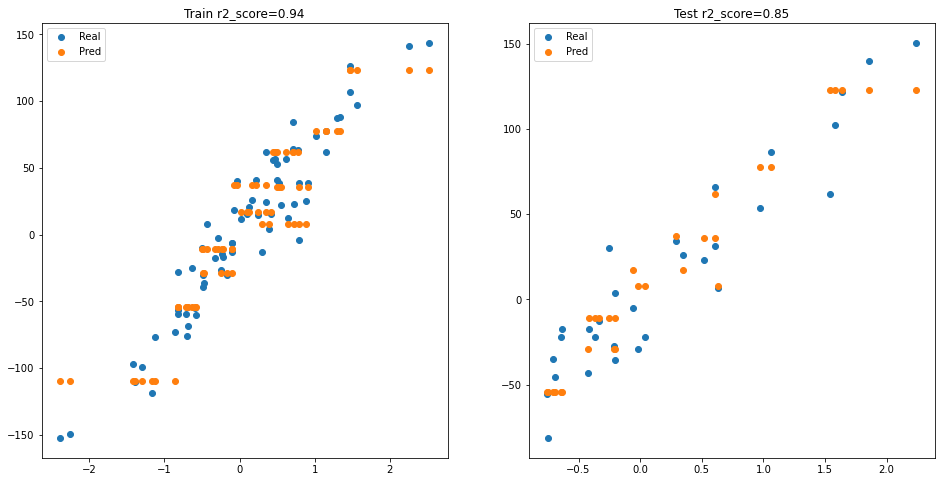

In [56]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)

plt.title(f'Train r2_score=0.94')
plt.scatter(train_X[:, 0], train_y)
plt.scatter(train_X[:, 0], y_pred_train)
plt.legend(['Real', 'Pred']);

plt.subplot(1,2,2)
plt.title(f'Test r2_score=0.85')
plt.scatter(test_X[:, 0], test_y)
plt.scatter(test_X[:, 0], y_pred_test)
plt.legend(['Real', 'Pred']);
plt.show()

## Вывод: Дерево неплохо справилось с задачей регрессии, на визуализации напоминает чем-то на квантование, хотя им и не является. В качестве критерия оценивания я взял R2-Score, на учебной выборке он составил 0.94, на тестовой 0.85.